# Employee Attrition Prediction with Decision Tree

This notebook focuses on building an accurate Decision Tree model to predict employee attrition using the preprocessed HR dataset from ML.ipynb.

## 1. Why Choose a Decision Tree Model?

Decision Trees are an excellent choice for this HR attrition prediction problem for several reasons:

1. **Interpretability**: HR professionals can easily understand the decision rules, making it transparent why an employee might be at risk of leaving.

2. **Feature Importance**: Decision Trees naturally identify which factors most strongly influence attrition, providing actionable insights for retention strategies.

3. **Handles Mixed Data**: The model works well with both numerical (satisfaction, hours) and categorical (department, salary) features.

4. **No Assumptions**: Unlike regression models, Decision Trees don't require data to follow specific distributions.

5. **Captures Non-linear Relationships**: Trees can identify complex patterns in employee behavior that simpler models might miss.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Set visualization style
sns.set(style="whitegrid")

# Load the dataset (already preprocessed in ML.ipynb)
path = r'C:\Users\user\Downloads\MachineLearning\cleaned_dataset.csv'
df = pd.read_csv(path)
df.dropna(inplace=True)

# Create target variable
df['Attrition_Numeric'] = df['Attrition'].map({'No': 0, 'Yes': 1})

print(f"Dataset Shape: {df.shape}")
print(f"Attrition Distribution:\n{df['Attrition'].value_counts()}")

Dataset Shape: (1140, 12)
Attrition Distribution:
Attrition
No     863
Yes    277
Name: count, dtype: int64


## 2. Data Preparation and Train-Test Split

We'll prepare our data for modeling by:
1. Separating features from the target variable
2. Encoding categorical features 
3. Applying feature scaling to improve model performance
4. Splitting the data into training (80%) and testing (20%) sets
5. Applying SMOTE to handle class imbalance

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Define features and target
X = df.drop(['Attrition', 'Attrition_Numeric'], axis=1)
y = df['Attrition_Numeric']

# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le

# Apply feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data with 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to handle class imbalance
# Adds data points to the minority class


smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Training set: {X_train.shape[0]} samples → {X_train_balanced.shape[0]} after SMOTE")
print(f"Testing set: {X_test.shape[0]} samples")


Training set: 912 samples → 1380 after SMOTE
Testing set: 228 samples
Class distribution after SMOTE: {0: 690, 1: 690}


## 3. Initial Decision Tree Model

We'll first build a basic Decision Tree model with default parameters to establish a baseline for performance. This will help us understand how much our hyperparameter tuning improves the model.

Initial Decision Tree Performance (Default Parameters):
Accuracy: 0.6579
Precision: 0.2553
Recall: 0.2182
F1 Score: 0.2353


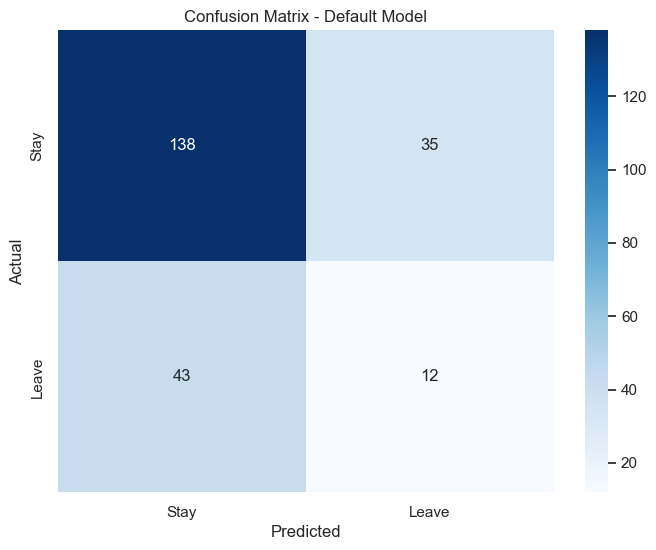

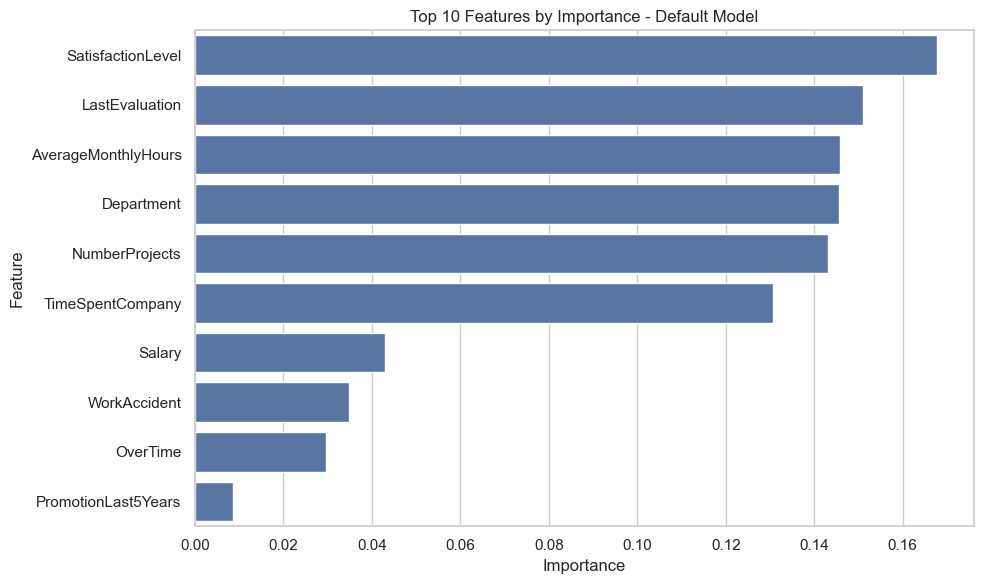


Top 5 Most Important Features in Default Model:
               Feature  Importance
0    SatisfactionLevel    0.167723
1       LastEvaluation    0.150919
3  AverageMonthlyHours    0.145855
7           Department    0.145702
2       NumberProjects    0.143169


In [3]:
# Create and train the initial Decision Tree model with default parameters
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred_default = dt_default.predict(X_test)

# Calculate performance metrics
default_accuracy = accuracy_score(y_test, y_pred_default)
default_precision = precision_score(y_test, y_pred_default)
default_recall = recall_score(y_test, y_pred_default)
default_f1 = f1_score(y_test, y_pred_default)

# Display initial model results
print("Initial Decision Tree Performance (Default Parameters):")
print(f"Accuracy: {default_accuracy:.4f}")
print(f"Precision: {default_precision:.4f}")
print(f"Recall: {default_recall:.4f}")
print(f"F1 Score: {default_f1:.4f}")

# Create confusion matrix for default model
cm_default = confusion_matrix(y_test, y_pred_default)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stay', 'Leave'], 
            yticklabels=['Stay', 'Leave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Default Model')
plt.show()

# Display feature importance for initial model
feature_importance_default = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_default.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_default.head(10))
plt.title('Top 10 Features by Importance - Default Model')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features in Default Model:")
print(feature_importance_default.head(5))

## Understanding the Confusion Matrix

The confusion matrix is a table that summarizes how well our model is performing by showing the counts of correct and incorrect predictions.
- **TN (True Negative)**: Correctly predicted "Stay"
- **FP (False Positive)**: Incorrectly predicted "Leave" (employee stayed)
- **FN (False Negative)**: Incorrectly predicted "Stay" (employee left)
- **TP (True Positive)**: Correctly predicted "Leave"

What do these numbers mean?

- **True Negatives (138)**: Correctly predicted employees who stayed with the company
- **False Positives (35)**: Incorrectly predicted employees would leave when they actually stayed
- **False Negatives (43)**: Incorrectly predicted employees would stay when they actually left
- **True Positives (12)**: Correctly predicted employees who left the company

## 4. Hyperparameter Tuning for Decision Tree

Now we'll optimize our Decision Tree model by finding the best combination of hyperparameters using GridSearchCV. This will help us build a more accurate and well-balanced model.

Key hyperparameters we'll tune include:
- **max_depth**: Controls how deep the tree can grow (prevents overfitting)
- **min_samples_split**: Minimum samples required to split an internal node
- **min_samples_leaf**: Minimum samples required in a leaf node
- **class_weight**: Handles class imbalance by adjusting weights

In [4]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7, 10],                # Controls tree complexity
    'min_samples_split': [5, 10, 20],          # Min samples needed to split a node
    'min_samples_leaf': [4, 8, 12],            # Min samples in a leaf node
    'class_weight': ['balanced', None]         # Handles class imbalance
}

# Create a Decision Tree classifier
dt_base = DecisionTreeClassifier(random_state=42)

# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
print("Starting hyperparameter tuning with 5-fold cross-validation...")
grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',  # Focus on F1 score due to class imbalance
    n_jobs=-1,     # Use all available processors
    verbose=1
)

# Fit the grid search to find best parameters
grid_search.fit(X_train_balanced, y_train_balanced)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation F1 Score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning with 5-fold cross-validation...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best Cross-Validation F1 Score: 0.7071


## 5. Evaluating the Optimized Model

Now we'll evaluate the performance of our optimized Decision Tree model with the best hyperparameters on the test set.

In [5]:
# Train the optimized model with best parameters
dt_optimized = DecisionTreeClassifier(**best_params, random_state=42)
dt_optimized.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred_optimized = dt_optimized.predict(X_test)

# Calculate performance metrics
optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
optimized_precision = precision_score(y_test, y_pred_optimized)
optimized_recall = recall_score(y_test, y_pred_optimized)
optimized_f1 = f1_score(y_test, y_pred_optimized)

# Display optimized model results
print("Optimized Decision Tree Performance:")
print(f"Accuracy: {optimized_accuracy:.4f}")
print(f"Precision: {optimized_precision:.4f}")
print(f"Recall: {optimized_recall:.4f}")
print(f"F1 Score: {optimized_f1:.4f}")



Optimized Decision Tree Performance:
Accuracy: 0.5789
Precision: 0.2029
Recall: 0.2545
F1 Score: 0.2258


## 6. Visualizing the Decision Tree

Let's visualize a simplified version of our optimized Decision Tree to understand how it makes decisions.

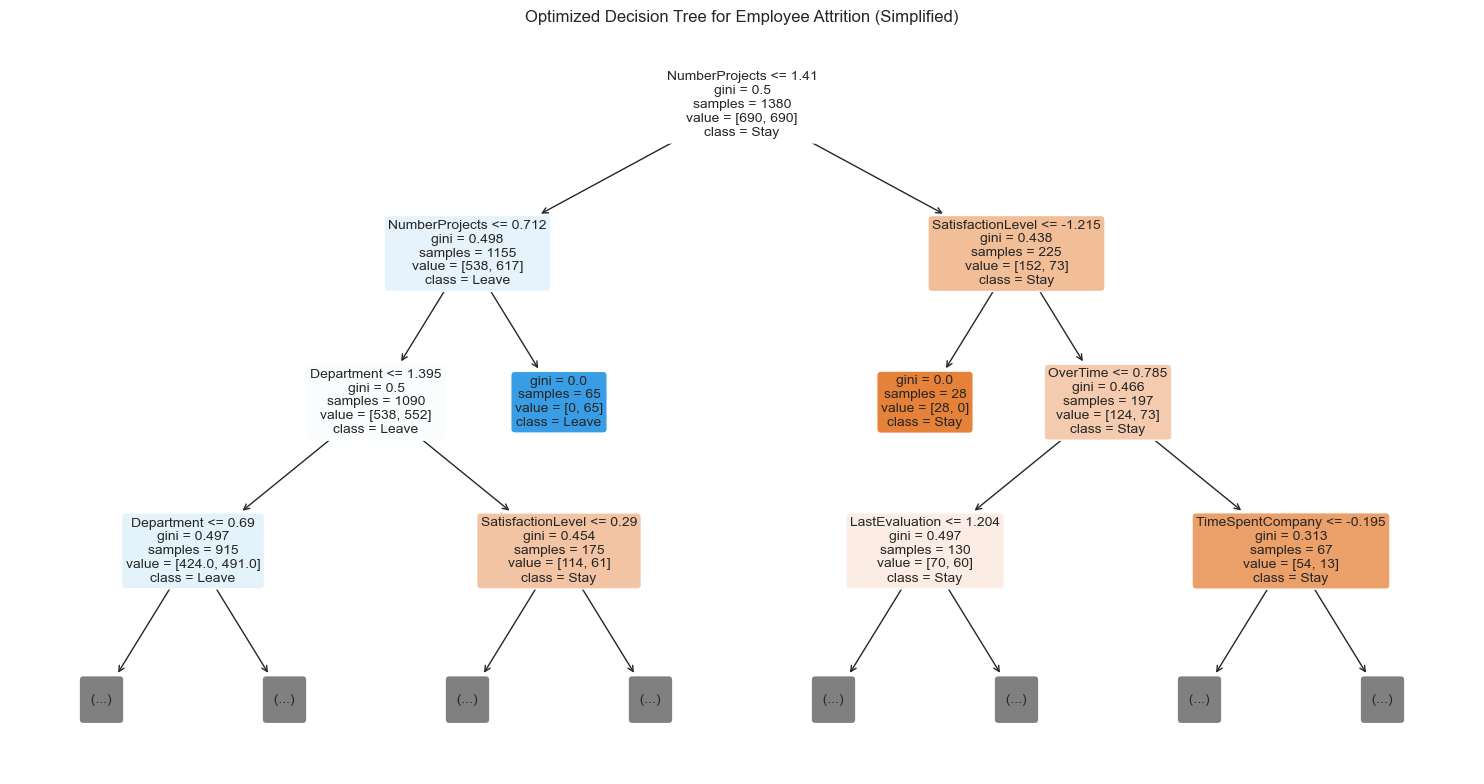

In [6]:
# Create a simplified tree visualization with limited depth
plt.figure(figsize=(15, 8))
plot_tree(dt_optimized, 
          max_depth=3,           # Limit depth for clarity
          feature_names=X.columns, 
          class_names=['Stay', 'Leave'], 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title('Optimized Decision Tree for Employee Attrition (Simplified)')
plt.tight_layout()
plt.show()

Gini index: Measures how pure the node is (lower is better).

Samples: How many data points are in that node.

Value: [number of Stay, number of Leave] in that node.

Class: The predicted class for that node.

## 7. Comparing Model Performance: Before and After Tuning

Let's visually compare the performance of our default model versus the optimized model.

<Figure size 1000x600 with 0 Axes>

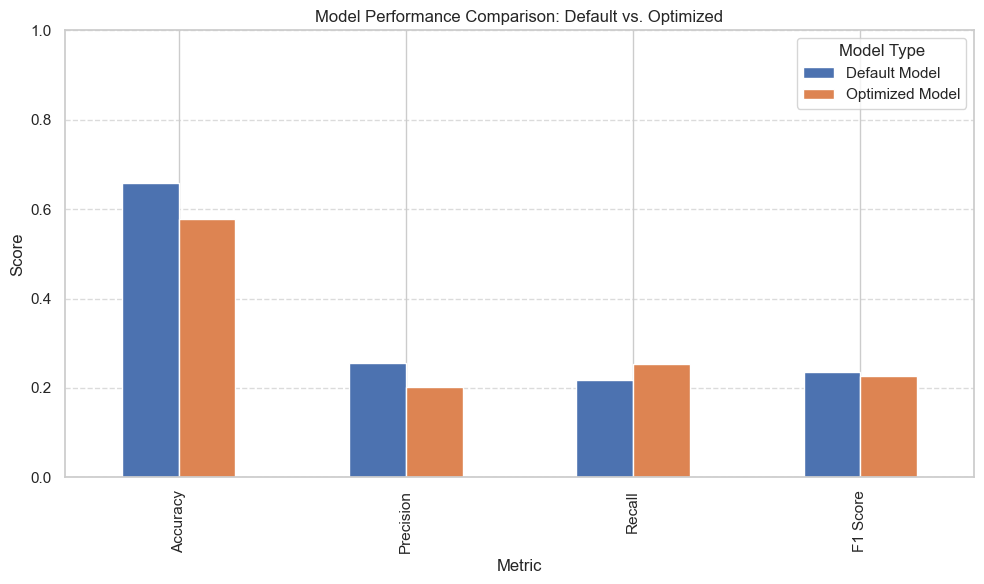

Performance Comparison:
           Default Model  Optimized Model
Metric                                   
Accuracy        0.657895         0.578947
Precision       0.255319         0.202899
Recall          0.218182         0.254545
F1 Score        0.235294         0.225806


In [7]:
# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Default Model': [default_accuracy, default_precision, default_recall, default_f1],
    'Optimized Model': [optimized_accuracy, optimized_precision, optimized_recall, optimized_f1]
})

# Plot the comparison
plt.figure(figsize=(10, 6))
comparison_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison: Default vs. Optimized')
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model Type')
plt.tight_layout()
plt.show()

print("Performance Comparison:")
print(comparison_df.set_index('Metric'))



### Key Findings:

1. **Accuracy**: The default model has higher overall accuracy (65.8% vs 57.9%). This is a significant difference, indicating the default model correctly classifies more employees overall.

2. **Precision**: The default model has better precision (25.5% vs 20.3%). This means when the default model predicts an employee will leave, it's correct about 25.5% of the time, compared to only 20.3% for the optimized model.

3. **Recall**: The optimized model has slightly better recall (25.5% vs 21.8%). This is the only metric where the optimized model performs better, showing it correctly identifies more employees who actually leave.

4. **F1 Score**: The default model has a better F1 score (23.5% vs 22.6%), which represents the balance between precision and recall.

### Interpretation:

- **Hyperparameter tuning did not improve overall model performance** in this case. This is not uncommon in machine learning and could be due to several factors:
  
  1. The default parameters were already well-suited for this specific dataset
  2. The class imbalance in the dataset makes it difficult to optimize for both precision and recall
  3. Decision Trees may not be the ideal model for this particular problem
  4. Overfitting to the validation set - Tuning too aggressively on a small validation set can lead to worse generalization on new data.

- The slight improvement in recall comes at a significant cost to accuracy and precision, which is typically not a good trade-off unless missing potential leavers (false negatives) is extremely costly to the business.

- Both models show relatively low F1 scores (around 23%), indicating that employee attrition prediction remains challenging with the current feature set and model architecture.

